<a href="https://colab.research.google.com/github/pintophr/Surveying_the_Future_of_Computer_and_Data_Science_Education/blob/main/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Settings
Preparing the programming environment for data analysis.

In [ ]:
# Facilities required for installation.
!pip install pingouin
!pip install factor_analyzer
!pip install rpy2

In [2]:
# Importing libraries.
import pandas as pd # A powerful data manipulation and analysis tool.
import pingouin as pg # Statistical calculation (based on pandas).
import numpy as np # Linear algebra.
import matplotlib.pyplot as plt # An interface for plotting graphs.
import seaborn as sns # Data visualization (based on matplotlib).
import io # Standard Python library for handling various types of input and output operations.
import warnings # # Offers a way to manage warnings raised during runtime.
import textwrap # Wrapping and formatting plain text.
import rpy2.robjects as robjects # Allows Python to interface with the R language.


from matplotlib.colors import ListedColormap # Custom colormap for matplotlib.
from google.colab import files #  A module in Google Colab for handling files.
from scipy.stats import spearmanr # Spearman's correlation.
from factor_analyzer import FactorAnalyzer # EFA.
from factor_analyzer.factor_analyzer import calculate_kmo # KMOs' test.
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity # Bartletts' test.
from rpy2.robjects.packages import importr # A function to import R packages.
from rpy2.robjects import pandas2ri # A module to convert between pandas and R data structures.
from rpy2.robjects.vectors import StrVector # A class for handling R's string vectors.

In [3]:
# Load the R magic extension.
%load_ext rpy2.ipython

In [ ]:
%%R

# Package required for R's environment.
# psych: designed for multivariate analysis and psychological research.
# GPArotation: designed for factorial analysis.
install.packages(c("psych", "GPArotation"))

In [ ]:
%%R

# Loading packages.
library(psych)
library(GPArotation)

In [6]:
# Filter all FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

Loading CI/UFPB students' dataset.


In [7]:
# Delete all datasets loaded.
!rm *.csv

# Loading CI/UFPB students' data
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['LLMs_dataset(UFPB).csv']), encoding='ISO-8859-1', delimiter=';')

rm: cannot remove '*.csv': No such file or directory


Saving LLMs_dataset(UFPB).csv to LLMs_dataset(UFPB).csv


# 2. Descriptive Statisctics

In [8]:
# Questionnaires' columns.
pd.DataFrame(df.columns, columns=['Column Name'])

,Column Name
0,Li e compreendi que a qualquer momento posso d...
1,Qual é o seu gênero?
2,Qual é o seu curso?
3,"Em qual categoria você se encontra, aproximada..."
4,"Qual a sua idade, aproximadamente?"
5,Qual seu nível de conhecimento sobre LLMs (Cha...
6,Quais LLMs você utiliza?
7,Sinto que aprendo o que realmente me interessa...
8,"Muitas vezes, fico tão empolgado que perco a n..."
9,"LLMs (ChatGPT, Bard etc.) tornam a programação..."


In [9]:
# Checking for missing values.
valores_nulos = df.isnull().sum().sum()
print(f'NaNs: {valores_nulos}')

NaNs: 0


Creating a chart to visualize the gender frequencies.

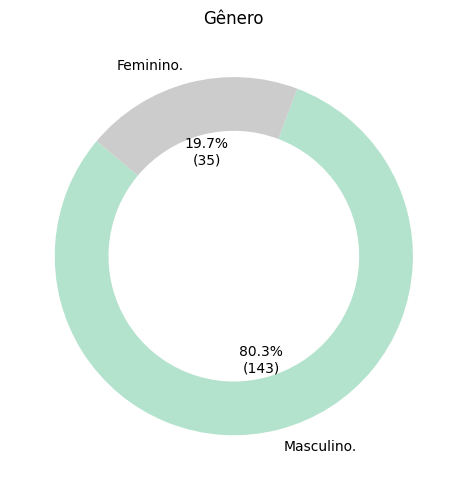

In [10]:
gender_counts = df["Qual é o seu gênero?"].value_counts()

# Function to display percentage and count on pie chart.
def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Gender Chart.
fig, ax = plt.subplots(figsize=(6, 5)) # Adjusting figure size to better fit a single chart
colors_gender = plt.cm.Pastel2(np.linspace(0, 1, len(gender_counts)))
gender_counts.plot(kind='pie', ax=ax, colors=colors_gender, autopct=lambda pct: func(pct, gender_counts), startangle=140, wedgeprops=dict(width=0.3))
ax.set_title('Gênero')
ax.set_ylabel('')  # Removing y-axis label to clean up the chart

plt.tight_layout()
plt.show()


Cheking how the data are scored.

In [11]:
# Finding the maximum and minimum value in a sample.
minimum_value = df['Utilizo LLMs (ChatGPT, Bard etc.) para tirar dúvidas e preencher lacunas no meu conhecimento sobre programação.'].min()
maximum_value = df['Utilizo LLMs (ChatGPT, Bard etc.) para tirar dúvidas e preencher lacunas no meu conhecimento sobre programação.'].max()

# Displaying the values found.
print("minimum_value:", minimum_value)
print("maximum value:", maximum_value)

minimum_value: 0
maximum value: 6


# 3. Exploartory Factorial Analysis (EFA)

## 3.1 Dataframe's configuration

Adjusting Linkert Scales from 0-6 to 1-7.

In [12]:
# It is better to have a true midpoint on the scales for performing data analysis.On dataset, all scales are rated from 0 to 6. So the convertion is needed.
# List of columns (items) you want to adjust.
itens = [
    'Qual seu nível de conhecimento sobre LLMs (ChatGPT, Bard etc.)?',
    'Sinto que aprendo o que realmente me interessa no meu curso.',
    'Muitas vezes, fico tão empolgado que perco a noção do tempo quando estou envolvido em um projeto ou atividade acadêmica.',
    'LLMs (ChatGPT, Bard etc.) tornam a programação mais democrática e acessível para as pessoas.',
    'Me sinto confiante com os textos e/ou códigos gerados por LLMs (ChatGPT, Bard etc.).',
    'Nunca me sinto capaz de alcançar meus objetivos acadêmicos.',
    'Utilizo LLMs (ChatGPT, Bard etc.) para tirar dúvidas e preencher lacunas no meu conhecimento sobre programação.',
    'Para mim, aprender sobre programação é um interesse pessoal.',
    'Prefiro programar sem ajuda de LLMs (ChatGPT, Bard etc.).',
    'Me divirto quando aprendo e adquiro novos conhecimentos sobre tecnologia.',
    'As demandas do meu curso me deixam emocionalmente cansado(a).',
    'Acredito que LLMs (ChatGPT, Bard etc.) podem ser melhor exploradas pelos professores nas aulas, atividades e/ou provas.',
    'Gosto de ir em todos as aulas do meu curso.',
    'Sinto que tenho as habilidades necessárias para ir bem em provas de programação.',
    'Não tenho interesse em programação competitiva (ICPC, CodeJam etc.).',
    'Penso que LLMs (ChatGPT, Bard etc.) são muito eficientes em programação.',
    'Tento me envolver em atividades extracurriculares do curso para me destacar.',
    'Tenho dificuldade para relaxar depois das aulas.',
    'Sinto que estou apenas memorizando informações em vez de realmente entender os conteúdos.',
    'Me preocupo que programadores sejam substituídos pelos modelos de inteligência artificial.',
    'Utilizo LLMs (ChatGPT, Bard etc.) para formular e resolver atividades de programação.',
    'Sou pressionado pelas demandas do curso.',
    'Corrijo meus códigos utilizando LLMs (ChatGPT, Bard etc.).',
    'Fico esgotado quando tenho que ir à universidade.',
    'Tenho dificuldade para encontrar erros em respostas e códigos gerados por LLMs (ChatGPT, Bard etc.).',
    'Deixo para estudar para as provas de última hora.',
    'Tenho medo que modelos de inteligência artificial tornem conteúdos que aprendi na faculdade obsoletos.',
    'Tento ir bem nas provas para agradar meus professores.',
    'Utilizo LLMs (ChatGPT, Bard etc.) para planejar meus estudos em programação.',
    'Sinto como se não pudesse acompanhar as mudanças causadas pelos modelos de inteligência artificial.',
    'Sinto tremores ou inquietações no corpo, como nas mãos ou nas pernas.'
]

# Add 1 to each item.
for item in itens:
    df[item] = df[item] + 1

# Finding the maximum and minimum value in a sample again.
minimum_value = df['Utilizo LLMs (ChatGPT, Bard etc.) para tirar dúvidas e preencher lacunas no meu conhecimento sobre programação.'].min()
maximum_value = df['Utilizo LLMs (ChatGPT, Bard etc.) para tirar dúvidas e preencher lacunas no meu conhecimento sobre programação.'].max()

# Displaying the values found.
print("minimum_value:", minimum_value)
print("maximum value:", maximum_value)

minimum_value: 1
maximum value: 7


Preparing the instruments' dataframes with respective items.

In [13]:
# Dictionary containing descriptions for the scales.
nomes_descritivos = {
    'scale_disfunctional_strategies': 'DLS/LLMs-3\n',
    'scale_metacognitive_strategies': 'MLS/LLMs-3\n',
}

# Dictionary containing the number of items in each scale.
num_items = {
    "scale_disfunctional_strategies": 3,
    "scale_metacognitive_strategies": 3
}

# Let’s group the items of the scales in separate dataframes.
# Dividing items (columns) into lists that correspond to psychometric scales.
scale_metacognitive_strategies = ['Utilizo LLMs (ChatGPT, Bard etc.) para tirar dúvidas e preencher lacunas no meu conhecimento sobre programação.', 'Utilizo LLMs (ChatGPT, Bard etc.) para formular e resolver atividades de programação.',   'Corrijo meus códigos utilizando LLMs (ChatGPT, Bard etc.).']
scale_disfunctional_strategies = ['Deixo para estudar para as provas de última hora.', 'Tenho dificuldade para encontrar erros em respostas e códigos gerados por LLMs (ChatGPT, Bard etc.).', 'Sinto que estou apenas memorizando informações em vez de realmente entender os conteúdos.']
scale_learning_strategies =['Utilizo LLMs (ChatGPT, Bard etc.) para tirar dúvidas e preencher lacunas no meu conhecimento sobre programação.', 'Utilizo LLMs (ChatGPT, Bard etc.) para formular e resolver atividades de programação.',   'Corrijo meus códigos utilizando LLMs (ChatGPT, Bard etc.).', 'Deixo para estudar para as provas de última hora.', 'Tenho dificuldade para encontrar erros em respostas e códigos gerados por LLMs (ChatGPT, Bard etc.).', 'Sinto que estou apenas memorizando informações em vez de realmente entender os conteúdos.']

# Creating the dataframes of the psychometric scales.
df_scale_metacognitive_strategies = df[scale_metacognitive_strategies]
df_scale_disfunctional_strategies = df[scale_disfunctional_strategies]
df_scale_learning_strategies = df[scale_learning_strategies]

In [14]:
# Loading scales dataframes to Rs' enviroment.

%R -i df_scale_learning_strategies

Creating a dataframe for the somatory of the scales.

In [15]:
# List with the names of the scales.
scales_names = ['scale_disfunctional_strategies', 'scale_metacognitive_strategies']

# Sum of the scales.
for scale in scales_names:
    df['Sum_' + scale] = globals()[f'df_{scale}'].sum(axis=1)

## 3.2 Samples Adequacy for Structural Detection


/usr/local/lib/python3.10/dist-packages/factor_analyzer/factor_analyzer.py:663: UserWarning: No rotation will be performed when the number of factors equals 1.
  warnings.warn(


KMO Test: 0.682
Bartlett's Test of Sphericity: chi-square=219.646, p-value=2.1e-38


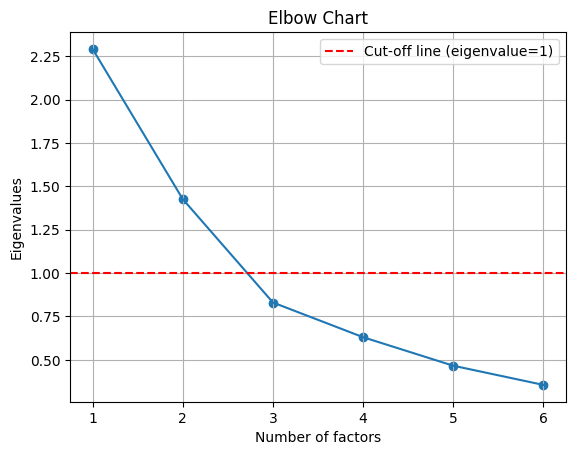

In [16]:
# Setting data.
data = df_scale_learning_strategies

# Extracting factors using the Principal Axis Factoring (PAF) method.
fa = FactorAnalyzer(n_factors=1, method='principal')
fa.fit(data)

# Loadings.
loadings = abs(fa.loadings_)
loadings_df = pd.DataFrame(loadings, columns=[f'Factor {i+1}' for i in range(loadings.shape[1])])

# Perform KMO test.
kmo_all, kmo_model = calculate_kmo(data)
print(f"KMO Test: {kmo_model:.3f}")

# Perform Bartlett's test of sphericity.
chi_square_value, p_value = calculate_bartlett_sphericity(data)
print(f"Bartlett's Test of Sphericity: chi-square={chi_square_value:.3f}, p-value={p_value:.3g}")

# Getting the eigenvalues based on Kaiser criterion.
eigen_values, vectors = fa.get_eigenvalues()

# Create Elbow Chart.
plt.scatter(range(1,data.shape[1]+1), eigen_values)
plt.plot(range(1, data.shape[1]+1), eigen_values)

# Add the cut line.
plt.axhline(y=1, color='r', linestyle='--', label='Cut-off line (eigenvalue=1)')
plt.legend()

plt.title('Elbow Chart')
plt.xlabel('Number of factors')
plt.ylabel('Eigenvalues')
plt.grid(True)
plt.show()

## 3.3 Internal Reliability Assessment

In [19]:
%%R

# Using the 'omega' function from the 'psych' package.
# The same result was obtained for different 'option' settings.
cat("Total Omega: ", omega_results$omega.tot, "\n")
cat("Cronbach's Alpha: ", omega_results$alpha, "\n")

Total Omega:  0.7391163 
Cronbach's Alpha:  0.6406201 


## 3.4 Loadings (PAF)

Variance Explained by each factor:
 [2.16462011 1.54688   ]
Proportional Variance Explained by each factor:
 [0.36077002 0.25781333]
Cumulative Variance Explained by each factor:
 [0.36077002 0.61858335]


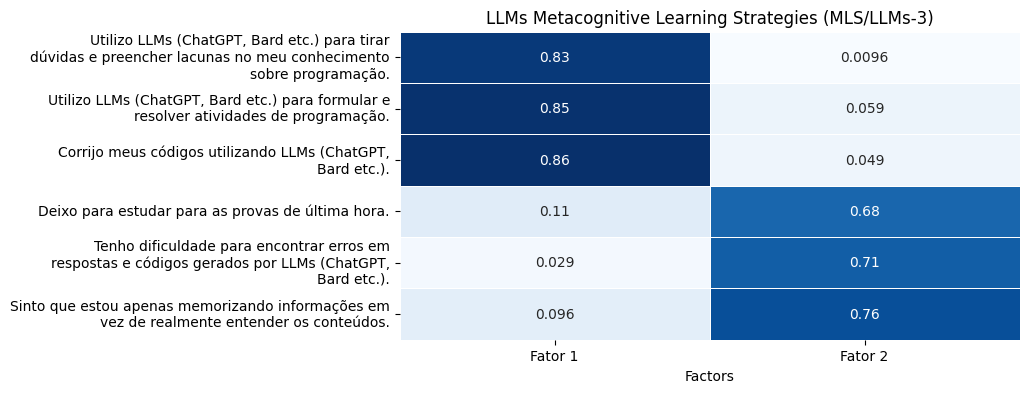

In [20]:
# Setting the number of factors based on parallel analysis.
n_factors = 2
data = df_scale_learning_strategies

fa = FactorAnalyzer(n_factors=n_factors, rotation='promax', method='principal')
fa.fit(data)
loadings = abs(fa.loadings_)

# Variance explained by each factor.
variance, proportional_variance, cumulative_variance = fa.get_factor_variance()
print("Variance Explained by each factor:\n", variance)
print("Proportional Variance Explained by each factor:\n", proportional_variance)
print("Cumulative Variance Explained by each factor:\n", cumulative_variance)

# Creating a heatmap of the loadings of the items with labels and adjusted cell height.
item_names = data.columns
plt.figure(figsize=(8, 4))
sns.heatmap(loadings, annot=True, cmap='Blues', linewidths=0.5,
            yticklabels=[textwrap.fill(item, 50) for item in item_names],
            xticklabels=[f'Fator {i+1}' for i in range(n_factors)], cbar=False)
plt.title('LLMs Metacognitive Learning Strategies (MLS/LLMs-3)')
plt.xlabel('Factors')
plt.show()

# 4. Spearman's Correlation Test

## 4.1 Gender x LSS/LLMs-6

In [22]:
# Encoding the gender column
gender_map = {'Masculino.': 1, 'Feminino.': 2}  # Replace with your gender categories
df['gender_encoded'] = df['Qual é o seu gênero?'].map(gender_map)

# Calculating Spearman Correlation
for scale in scales_names:
    correlation, p_value = spearmanr(df['Sum_' + scale], df['gender_encoded'])
    print(f"Spearman Correlation between Sum_{scale} and Gender: {correlation}, p-value: {p_value}")

Spearman Correlation between Sum_scale_disfunctional_strategies and Gender: -0.014916712422160838, p-value: 0.8433403077526923
Spearman Correlation between Sum_scale_metacognitive_strategies and Gender: 0.03987934881246387, p-value: 0.5971393632815666


## 4.2 Course progress x LS/LLMs-6

In [23]:
# Encoding the course progress column
grade_map = {'Estou no início do curso (até 25%).': 1, 'Estou na primeira metade do curso (entre 25 e 50%).': 2, 'Estou na segunda metade do curso (entre 50% e 75%).': 3, 'Estou no final do curso (mais de 75%).': 4}  # Replace with your gender categories
df['grade_encoded'] = df['Em qual categoria você se encontra, aproximadamente?'].map(grade_map)

# Calculating Spearman Correlation
for scale in scales_names:
    correlation, p_value = spearmanr(df['Sum_' + scale], df['grade_encoded'])
    print(f"Spearman Correlation between Sum_{scale} and course progress: {correlation}, p-value: {p_value}")

Spearman Correlation between Sum_scale_disfunctional_strategies and course progress: -0.14565653123348307, p-value: 0.05238355254015278
Spearman Correlation between Sum_scale_metacognitive_strategies and course progress: -0.018116686134386967, p-value: 0.8103119979909422


## 4.3 Perceived LLMs knowledge x LS/LLMs-6

In [24]:
# Calculating Spearman Correlation
for scale in scales_names:
    correlation, p_value = spearmanr(df['Sum_' + scale], df['Qual seu nível de conhecimento sobre LLMs (ChatGPT, Bard etc.)?'])
    print(f"Spearman Correlation between Sum_{scale} and perceived LLMs knowledge: {correlation}, p-value: {p_value}")

Spearman Correlation between Sum_scale_disfunctional_strategies and perceived LLMs knowledge: -0.07301658588651759, p-value: 0.33274823579890567
Spearman Correlation between Sum_scale_metacognitive_strategies and perceived LLMs knowledge: 0.3353036250950572, p-value: 4.759032979101414e-06


## 4.4 Question about feeling exhausted from university x LSS/LLMs-6

In [25]:
# Calculating Spearman Correlation
for scale in scales_names:
    correlation, p_value = spearmanr(df['Sum_' + scale], df['Fico esgotado quando tenho que ir à universidade.'])
    print(f"Spearman Correlation between Sum_{scale} and felling exhausted: {correlation}, p-value: {p_value}")

Spearman Correlation between Sum_scale_disfunctional_strategies and felling exhausted: 0.4099829290666952, p-value: 1.3223974140616672e-08
Spearman Correlation between Sum_scale_metacognitive_strategies and felling exhausted: 0.06898574899906722, p-value: 0.3601963745677428


## 4.5 Question about feeling unable for academic sucess x LSS/LLMs-6

In [26]:
# Calculating Spearman Correlation
for scale in scales_names:
    correlation, p_value = spearmanr(df['Sum_' + scale], df['Nunca me sinto capaz de alcançar meus objetivos acadêmicos.'])
    print(f"Spearman Correlation between Sum_{scale} and felling unable for academic sucess: {correlation}, p-value: {p_value}")

Spearman Correlation between Sum_scale_disfunctional_strategies and felling unable for academic sucess: 0.4439413715339733, p-value: 5.404823109269942e-10
Spearman Correlation between Sum_scale_metacognitive_strategies and felling unable for academic sucess: 0.03889473257339146, p-value: 0.6062318681416659


## 4.6 Question about confidence and LS/LLMs-6

In [27]:
# Calculating Spearman Correlation
for scale in scales_names:
    correlation, p_value = spearmanr(df['Sum_' + scale], df['Me sinto confiante com os textos e/ou códigos gerados por LLMs (ChatGPT, Bard etc.).'])
    print(f"Spearman Correlation between Sum_{scale} and confidence about LLMs: {correlation}, p-value: {p_value}")

Spearman Correlation between Sum_scale_disfunctional_strategies and confidence about LLMs: 0.21752081682845112, p-value: 0.0035381334974008117
Spearman Correlation between Sum_scale_metacognitive_strategies and confidence about LLMs: 0.44702420028365136, p-value: 3.971604923310372e-10
